In [13]:
from skimage.segmentation import clear_border
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
%cd "/content/drive/MyDrive"

/content/drive/MyDrive


In [16]:
!pwd

/content/drive/MyDrive


In [17]:
data = 'cheque_data/images/train'

In [21]:
import os
train_images = os.listdir(data)
train_images

['Cheque120620.jpg', 'Cheque120619.jpg', 'Cheque120618.jpg']

In [22]:
import random
random_image_file = random.choice(train_images)

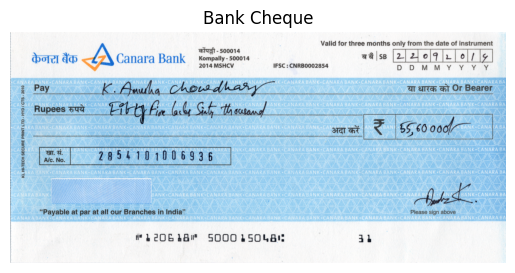

In [23]:

image_path = os.path.join(data, random_image_file)
image = Image.open(image_path)

plt.imshow(image)
plt.title("Bank Cheque")
plt.axis('off')
plt.show()

In [24]:
random_image = cv2.imread(image_path)

In [25]:
#PREPROCESSING
gray_image = cv2.cvtColor(random_image, cv2.COLOR_BGR2GRAY)
_, binary_image = cv2.threshold(gray_image, 150, 255, cv2.THRESH_BINARY)
kernel = np.ones((2, 2), np.uint8)
eroded_image = cv2.erode(binary_image, kernel, iterations=1)
eroded_image_bgr = cv2.cvtColor(eroded_image, cv2.COLOR_GRAY2BGR)

cv2.imwrite("preprocessed_image.jpg", eroded_image_bgr)

True

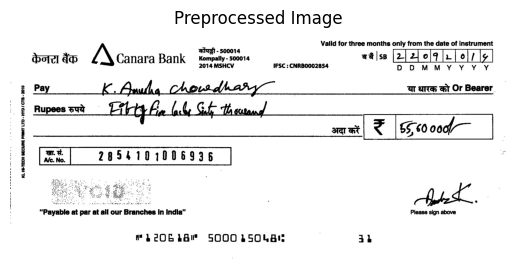

In [26]:
image = Image.open("preprocessed_image.jpg")

plt.imshow(image)
plt.title("Preprocessed Image")
plt.axis('off')
plt.show()

In [27]:
import matplotlib.pyplot as plt

def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(title)
    plt.grid(False)
    plt.show()

In [28]:
def extract_digits_and_symbols(image, charCnts, minW=5, minH=15):
    # grab the internal Python iterator for the list of character contours, then initialize the character ROI and location
    charIter = charCnts.__iter__()
    rois = []
    locs = []

    # keep looping over the character contours until we reach the end of the list
    while True:
        try:
            # compute its bounding box of next char, and initialize the ROI
            c = next(charIter)
            (cX, cY, cW, cH) = cv2.boundingRect(c)
            roi = None

            # check to see if the width and height are sufficiently large
            if cW >= minW and cH >= minH:
                # extract the ROI
                roi = image[cY:cY + cH, cX:cX + cW]
                rois.append(roi)
                locs.append((cX, cY, cX + cW, cY + cH))

            # otherwise, we are examining one of the special symbols
            else:
                parts = [c, next(charIter), next(charIter)]
                (sXA, sYA, sXB, sYB) = (np.inf, np.inf, -np.inf, -np.inf)

                # loop over the parts
                for p in parts:
                    # compute the bounding box for the part, then
                    (pX, pY, pW, pH) = cv2.boundingRect(p)
                    sXA = min(sXA, pX)
                    sYA = min(sYA, pY)
                    sXB = max(sXB, pX + pW)
                    sYB = max(sYB, pY + pH)

                # extract the ROI
                roi = image[sYA:sYB, sXA:sXB]
                rois.append(roi)
                locs.append((sXA, sYA, sXB, sYB))

        # we have reached the end of the iterator
        except StopIteration:
            break

    # return a tuple of the ROIs and locations
    return (rois, locs)



In [30]:
args = {
	"image": "preprocessed_image.jpg",
    "reference": "cheque_data/micr.jpg"
}

In [31]:
# construct the argument parse and parse the arguments


# initialize the list of reference character names, in the same
# order as they appear in the reference image where the digits
# their names and:
# T = Transit (delimit bank branch routing transit #)
# U = On-us (delimit customer account number)
# A = Amount (delimit transaction amount)
# D = Dash (delimit parts of numbers, such as routing or account)
charNames = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "0",
    "T", "U", "A", "D"]

#convert  MICR to grayscale and threshold it,
ref = cv2.imread(args["reference"])
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
ref = imutils.resize(ref, width=400)
ref = cv2.threshold(ref, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

# find contours in the MICR image
refCnts = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
refCnts = imutils.grab_contours(refCnts)
refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]

In [32]:
# extract the digits and symbols from the list of contours
refROIs = extract_digits_and_symbols(ref, refCnts, minW=10, minH=20)[0]
chars = {}

# loop over the reference ROIs
for (name, roi) in zip(charNames, refROIs):
    roi = cv2.resize(roi, (36, 36))
    chars[name] = roi

# initialize a list to store the output of the check OCR
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 7))
output = []


In [33]:
# load the input image
image = cv2.imread(args["image"])
(h, w,) = image.shape[:2]
delta = int(h - (h * 0.2))
bottom = image[delta:h, 0:w]

# convert to grayscale, then apply a blackhat morphological operator
gray = cv2.cvtColor(bottom, cv2.COLOR_BGR2GRAY)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)

# compute the Scharr gradient of the blackhat image
gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")

# apply a closing operation using the rectangular kernel
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

thresh = clear_border(thresh)

In [34]:
# find contours in the thresholded image, then initialize the list of group locations
groupCnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
groupCnts = groupCnts[0] if imutils.is_cv2(or_better=True) else groupCnts[1]
groupLocs = []

# loop over the group contours
for (i, c) in enumerate(groupCnts):
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)
    groupLocs.append((x, y, w, h))

groupLocs = sorted(groupLocs, key=lambda x:x[0])

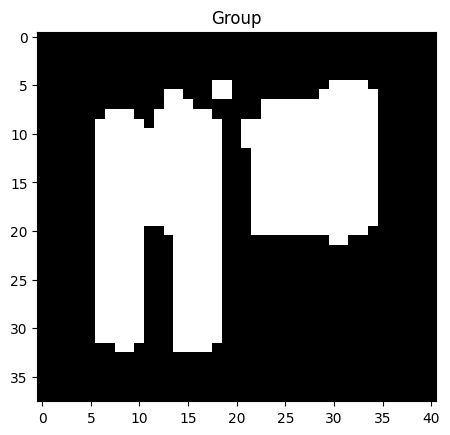

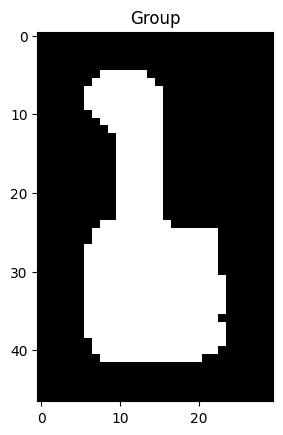

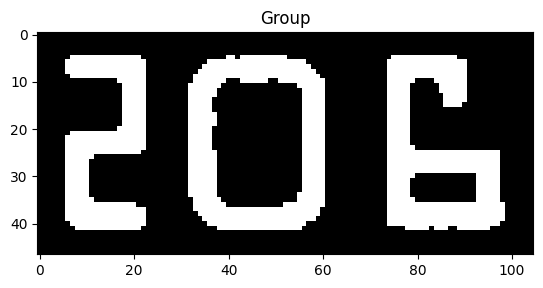

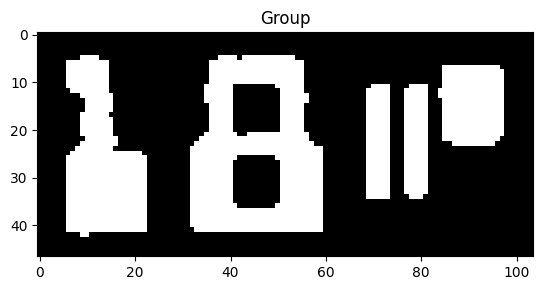

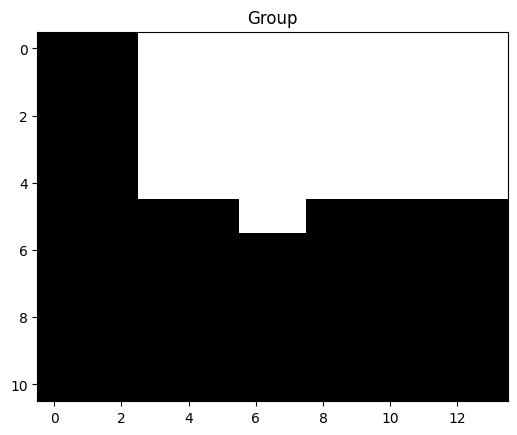

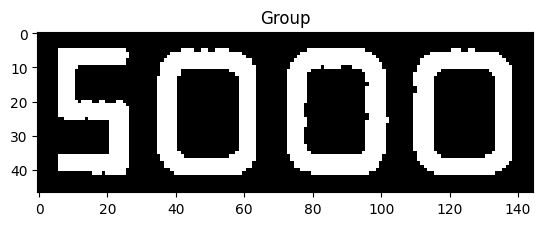

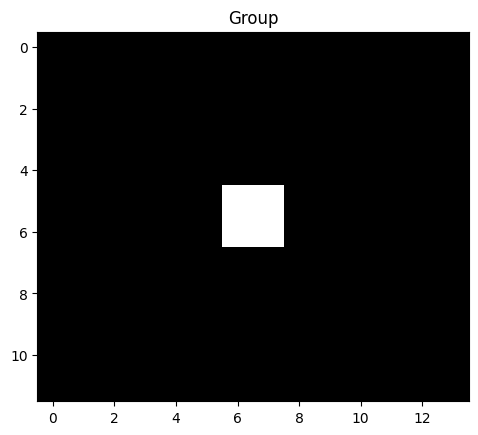

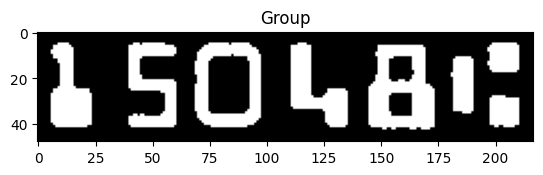

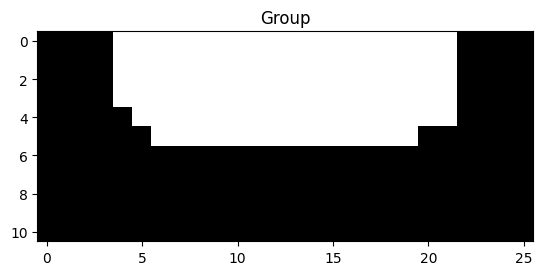

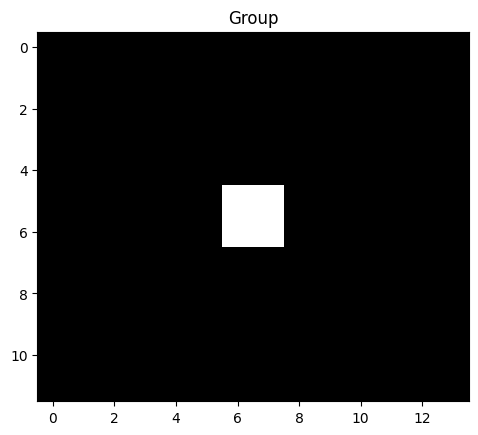

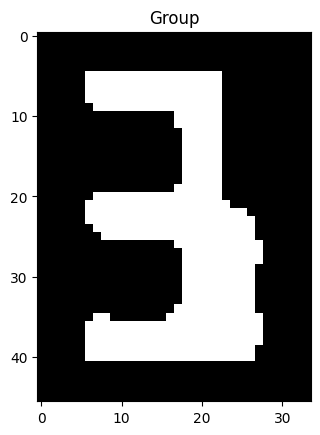

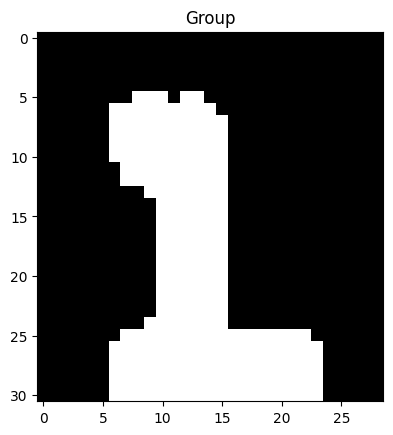

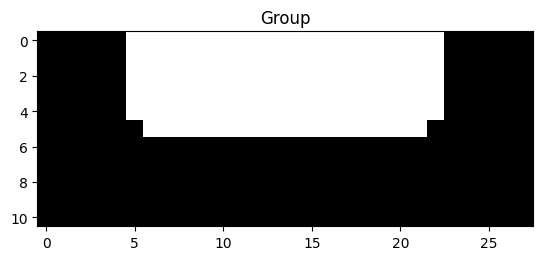

In [35]:
# loop over the group locations
for (gX, gY, gW, gH) in groupLocs:
    groupOutput = []

    # extract the group ROI of characters from the grayscale
    group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
    group = cv2.threshold(group, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    plt_imshow("Group", group)

    # find character contours in the group,
    charCnts = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    charCnts = imutils.grab_contours(charCnts)
    charCnts = contours.sort_contours(charCnts, method="left-to-right")[0]

    # find the characters and symbols in the group
    (rois, locs) = extract_digits_and_symbols(group, charCnts)

    # loop over the ROIs from the group
    for roi in rois:
        scores = []
        roi = cv2.resize(roi, (36, 36))

        # loop over the reference character name and corresponding
        # ROI
        for charName in charNames:
            # apply correlation-based template matching, take the
            # score, and update the scores list
            result = cv2.matchTemplate(roi, chars[charName], cv2.TM_CCOEFF)
            (_, score, _, _) = cv2.minMaxLoc(result)
            scores.append(score)

        groupOutput.append(charNames[np.argmax(scores)])

    # draw bounding box surrounding the group along with the OCR output of the group
    cv2.rectangle(image, (gX - 10, gY + delta - 10), (gX + gW + 10, gY + gY + delta), (0, 0, 255), 2)
    cv2.putText(image, "".join(groupOutput), (gX - 10, gY + delta - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.95, (0, 0, 255), 3)

    # add the group output to the overall check OCR output
    output.append("".join(groupOutput))

Cheque MICR OCR: T 1 206 18UU7  5000  150487   3 1 


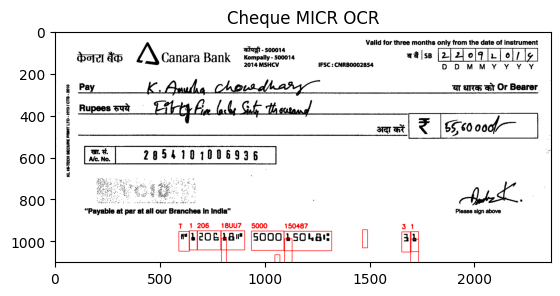

In [36]:
# display the output check OCR information to the screen
print("Cheque MICR OCR: {}".format(" ".join(output)))
plt_imshow("Cheque MICR OCR", image)